# Introduction

This report is an analysis of the challenge named "How to explain electricity price?" hosted by Qube Research and Technology on challengedata.ens.fr. The challenge focuses on modeling the daily variation in electricity prices based on meteorological, energy, and commercial data for two European countries - France and Germany. In particular, the challenge is to explain price changes with other simultaneous variables rather than just predicting them.

In assessing the accuracy of participants' models, the challenge employed the Spearman rank correlation as its scoring metric. This non-parametric measure evaluates the monotonic relationship between two datasets, making it apt for volatile data like electricity price variations. By emphasizing the order of variations rather than their precise values, the Spearman correlation offers a more robust assessment against outliers. Consequently, it ensures that models are rewarded for capturing the underlying trends in price changes without being unduly penalized for occasional discrepancies in magnitude.

To tackle this challenge, we will employ the Cross-Industry Standard Process for Data Mining (CRISP-DM). CRISP-DM is a robust and well-structured methodology that provides a structured approach to planning a data mining project. It includes five phases: Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation.

# Business understanding

The electricity price varies according to numerous factors, such as local climate variations, long-term phenomena like global warming, and geopolitical events. These factors affect both the production and demand for electricity. Furthermore, each country relies on a unique energy mix (nuclear, solar, hydro, gas, coal, etc.), and the price of these raw materials is also a key determinant of electricity prices. In addition to these factors, countries trade electricity with their neighbors through dynamic markets, which also influence the price.

The objective of the challenge is to model the electricity price based on meteorological data, energy data (raw materials), and commercial data. Specifically, the goal is to construct a model that provides a good estimation of the daily variation in the price of future contracts for electricity in France or Germany. These future contracts allow buying (or selling) a given quantity of electricity at a fixed price specified by the contract, to be delivered at a specified future date.

In the context of this project, we limit ourselves to short-term futures (24h). The futures market provides an estimation of the electricity value at the time of the contract's maturity based on current market conditions. Therefore, understanding and modeling these price variations can provide valuable insights and potential financial benefits.

# Data understanding

To understand the impact of various factors on electricity prices, we have access to daily measurements of meteorological data (temperature, rainfall, and wind strength), energy production data (price variations of different raw materials/energies), and electricity usage data (consumption, exchanges between the two countries, import-export with the rest of Europe) for each country.

Let's start by examining the data provided for the challenge. We will load the data, perform an initial exploration to understand its structure, check for missing values, and understand the basic statistics of the dataset.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
data_x_raw = pd.read_csv('data/raw/Data_x.csv', index_col='ID')
data_y_raw = pd.read_csv('data/raw/Data_y.csv', index_col='ID')
data_raw = pd.merge(data_x_raw, data_y_raw, on='ID')

data_raw.head()

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,-0.692860,...,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.028313
2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,...,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,...,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840
297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,...,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,-0.260356
1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,-0.990324,...,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,-0.071733


The dataset contains 1494 records and 36 columns. The columns represent a variety of features, including:

- `ID`: the unique identifier for each record.
- `DAY_ID`: the day identifier.
- `COUNTRY`: the country for which the data is recorded (France or Germany).
- `DE_CONSUMPTION` and `FR_CONSUMPTION`: the consumption of electricity in Germany and France.
- `DE_FR_EXCHANGE` and `FR_DE_EXCHANGE`: the electricity exchange between Germany and France.
- `DE_NET_EXPORT` and `FR_NET_EXPORT`: the net export of electricity from Germany and France.
- `DE_NET_IMPORT` and `FR_NET_IMPORT`: the net import of electricity to Germany and France.
- Various forms of energy production in each country (`DE_GAS`, `FR_GAS`, `DE_COAL`, `FR_COAL`, etc.).
- Meteorological data for each country (`DE_RAIN`, `FR_RAIN`, `DE_WIND`, `FR_WIND`, `DE_TEMP`, `FR_TEMP`).
- Return rates for different energy types (`GAS_RET`, `COAL_RET`, `CARBON_RET`).
- `TARGET`: the target variable we are interested in predicting, which represents the daily variation in electricity price.

Most of the columns are numeric (float or integer), except for the `COUNTRY` column, which is categorical and represents which country the record pertains to (France or Germany).

It's worth noting that there are missing values in some columns (`DE_FR_EXCHANGE`, `FR_DE_EXCHANGE`, `DE_NET_EXPORT`, `FR_NET_EXPORT`, `DE_NET_IMPORT`, `FR_NET_IMPORT`, `DE_RAIN`, `FR_RAIN`, `DE_WIND`, `FR_WIND`, `DE_TEMP`, `FR_TEMP`). The handling of these missing values will be a crucial part of the data preparation process. The strategy for dealing with them will depend on their nature and the percentage of missing values.

In [4]:
data_raw.describe()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
count,1494.000000,1494.000000,1494.000000,1469.000000,1469.000000,1370.000000,1424.000000,1370.000000,1424.000000,1494.000000,...,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,591.861446,0.427442,-0.020032,-0.145508,0.145508,-0.256332,-0.072643,0.256332,0.072643,0.780699,...,-0.037831,0.019357,0.109480,0.123099,0.009451,0.008404,0.058126,0.061724,0.080510,0.089934
std,345.065043,0.673412,0.918995,0.970226,0.970226,0.957443,1.075830,0.957443,1.075830,0.850190,...,0.984233,1.051781,1.056243,1.054692,0.972394,1.003356,1.097768,1.033853,1.098624,1.034582
min,0.000000,-2.265563,-1.462350,-2.856874,-2.634831,-2.464849,-2.825331,-2.279619,-1.951516,-1.117260,...,-2.128531,-1.726420,-1.880419,-1.895319,-4.549638,-5.787097,-5.349463,-5.706442,-4.281790,-6.519268
25%,292.250000,-0.037421,-0.716771,-0.875213,-0.638867,-0.977214,-0.851500,-0.452252,-0.794843,0.134947,...,-0.642117,-0.503927,-0.652135,-0.672614,-0.618259,-0.647948,-0.624238,-0.458038,-0.522968,-0.219861
50%,591.000000,0.357061,-0.394166,-0.164287,0.164287,-0.306899,0.099455,0.306899,-0.099455,0.740006,...,-0.274901,-0.228147,-0.261571,-0.229031,-0.026306,-0.020889,0.008493,0.063312,0.054056,0.000000
75%,885.750000,0.922057,0.650533,0.638867,0.875213,0.452252,0.794843,0.977214,0.851500,1.399461,...,0.335237,0.154351,0.635050,0.824781,0.651832,0.699131,0.676415,0.641446,0.599094,0.269719
max,1215.000000,2.033851,3.300640,2.634831,2.856874,2.279619,1.951516,2.464849,2.825331,3.118082,...,7.756118,9.473201,5.085624,4.965028,2.858758,2.817239,5.674778,3.746576,5.471818,7.786578


The statistical summary provides more insights into the dataset:

The consumption of electricity (`DE_CONSUMPTION` and `FR_CONSUMPTION`), the exchange of electricity between Germany and France (`DE_FR_EXCHANGE` and `FR_DE_EXCHANGE`), and the net export and import of electricity (`DE_NET_EXPORT`, `FR_NET_EXPORT`, `DE_NET_IMPORT`, `FR_NET_IMPORT`) show significant variations. This indicates that the countries' electricity usage and exchange patterns vary considerably.

The production of different forms of energy in both countries (like `DE_GAS`, `FR_GAS`, `DE_COAL`, `FR_COAL`, etc.) also shows a wide range of values. This suggests that the energy mix in both countries varies from day to day, which can impact electricity prices.

The meteorological data (like `DE_RAIN`, `FR_RAIN`, `DE_WIND`, `FR_WIND`, `DE_TEMP`, `FR_TEMP`) also varies considerably. Changes in weather conditions could significantly impact the production of certain types of energy (like wind or solar), and thus, the electricity prices.

The return rates for different energy types (`GAS_RET`, `COAL_RET`, `CARBON_RET`) also show a wide range of values. This indicates that the prices for these energy sources are highly volatile, which can impact electricity prices.

The target variable (`TARGET`), representing the daily variation in electricity price, also shows a wide range of values. This confirms that electricity prices can vary significantly from day to day.

Overall, the dataset provides a wealth of information that could potentially explain the daily variations in electricity prices. The next step in the CRISP-DM process would be the Data Preparation phase, where we would handle missing values, normalize numerical variables, and possibly create new features.


# Data Preparation
In the Data Preparation phase, we need to prepare our dataset for modeling. This involves cleaning the data, dealing with missing values, transforming variables, and possibly creating new features.

## Dealing with Missing Values

As observed in the data understanding phase, some columns in our dataset have missing values. The strategy for dealing with missing values depends on their nature and the percentage of missing values in each column. There are several common strategies:

- Remove rows with missing values: This is usually done when the number of rows with missing values is relatively small compared to the total number of records.
- Imputation: Replace missing values with a calculated value, such as the mean, median, or mode. This method can be applied when the missing values can be reasonably estimated from other data.
- Predict missing values: More advanced methods involve using statistical or machine learning techniques to predict missing values based on other data.

Let's start by examining the percentage of missing values in each column.

In [5]:
# Calculate the percentage of missing values in each column
missing_values = data_raw.isnull().sum() * 100 / len(data_raw)

missing_values[missing_values > 0]

DE_FR_EXCHANGE    1.673360
FR_DE_EXCHANGE    1.673360
DE_NET_EXPORT     8.299866
FR_NET_EXPORT     4.685408
DE_NET_IMPORT     8.299866
FR_NET_IMPORT     4.685408
DE_RAIN           6.291834
FR_RAIN           6.291834
DE_WIND           6.291834
FR_WIND           6.291834
DE_TEMP           6.291834
FR_TEMP           6.291834
dtype: float64

The percentage of missing values in each column is relatively small, with the highest being around 8.3%. Given the nature of the data, one reasonable approach could be to fill missing values using imputation. For instance, we could use the median of each column to fill the missing values. This is a reasonable choice as the median is less sensitive to outliers compared to the mean.

### Imputation of Missing Values 

We will replace missing values in each column with the median of that column. We use the median because it is less sensitive to outliers than the mean.

In [6]:
num_cols = data_raw.select_dtypes(include=np.number).columns

# Impute missing values with the median of each column
data_raw[num_cols] = data_raw[num_cols].fillna(data_raw.median(numeric_only=True))

# Check if there are still any missing values
missing_values_filled = data_raw.isnull().sum()
missing_values_filled[missing_values_filled > 0]

Series([], dtype: int64)

All missing values have been filled successfully with the median of the respective columns. Now, there are no missing values in the dataset.

## Normalizing Numerical Variables
Many machine learning algorithms perform better when numerical input variables are scaled to a standard range. This includes algorithms that use a weighted sum of the input, like linear regression, and algorithms that use distance measures, like k-nearest neighbors.

One common approach to normalization is to scale variables to have a mean of 0 and a standard deviation of 1, also known as standardization. However, our dataset seems to be already normalized (zero mean and unit variance) as observed in the data understanding phase, so we will skip this step.

## Splitting Data for France and Germany

Since the dataset contains data for both France and Germany, we can split the data into two separate datasets, one for each country. This will allow us to build country-specific models to understand how different factors impact electricity prices in each country.

In [7]:
data_fr = data_raw[data_raw['COUNTRY'] == 'FR'].drop('COUNTRY', axis=1)
data_de = data_raw[data_raw['COUNTRY'] == 'DE'].drop('COUNTRY', axis=1)

In [8]:
# Keep only french columns (resp. german) in the french dataset (resp.german dataset)
data_fr = data_fr.filter(regex='^(?!DE)')
data_de = data_de.filter(regex='^(?!FR)')

In [9]:
data_fr.to_csv('data/prepared/Data_fr.csv', index=True)
data_de.to_csv('data/prepared/Data_de.csv', index=True)

The data for France and Germany have been split, and the unnecessary columns related to the other country have been removed. The resulting datasets are saved as Data_fr.csv and Data_de.csv, respectively, in the "Preprocessed_Data" directory. We will use these datasets for modeling and analysis specific to each country.

# Exploratory Data Analysis (EDA) for the France Energy Dataset

## Step 1: Loading and Initial Inspection

I'll start by reading the data and examining its basic structure and statistics.

In [10]:
data_fr = pd.read_csv('data/prepared/Data_fr.csv', index_col=['DAY_ID', 'ID']).sort_index()

data_fr.describe()

,FR_CONSUMPTION,FR_DE_EXCHANGE,FR_NET_EXPORT,FR_NET_IMPORT,FR_GAS,FR_COAL,FR_HYDRO,FR_NUCLEAR,FR_SOLAR,FR_WINDPOW,FR_RESIDUAL_LOAD,FR_RAIN,FR_WIND,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
count,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000
mean,0.033707,0.125577,-0.019134,0.019134,0.397208,-0.390668,0.163946,-0.332241,0.543592,0.362208,-0.087124,0.009796,0.012158,0.001190,0.039947,0.069333,0.074805,0.046026
std,0.943071,0.941651,1.016158,1.016158,0.925580,0.530913,1.054493,0.989031,1.060339,1.174623,0.922673,1.006920,0.999460,0.979818,1.091868,1.043115,1.096573,1.023512
min,-1.462350,-2.634831,-2.825331,-1.951516,-1.317350,-0.794950,-1.758523,-2.595326,-1.312588,-1.143277,-1.678936,-1.726420,-1.895319,-5.787097,-5.349463,-5.706442,-4.281790,-6.519268
25%,-0.699925,-0.602534,-0.710545,-0.757525,-0.213153,-0.778677,-0.639208,-0.863334,-0.343903,-0.550885,-0.768812,-0.484767,-0.697246,-0.595664,-0.647117,-0.459531,-0.530523,-0.178023
50%,-0.365601,0.164287,0.099455,-0.099455,0.244309,-0.757349,-0.079222,-0.245237,0.483360,-0.009072,-0.409541,-0.228147,-0.264217,-0.020889,0.000000,0.071501,0.054056,-0.003619
75%,0.739198,0.828152,0.757525,0.710545,1.127789,-0.145822,0.852186,0.248058,1.268300,0.930943,0.492683,0.130232,0.491794,0.648230,0.655334,0.647094,0.633048,0.174344
max,3.300640,2.856874,1.951516,2.825331,2.372570,1.905512,3.730478,1.854408,3.648905,4.965793,2.918326,9.473201,4.965028,2.817239,5.674778,3.746576,5.471818,7.786578


From the basic statistics:

- Many of the features exhibit a mean close to zero, suggesting possible standardization.
- Variables like FR_RAIN and TARGET have broad ranges, hinting at the presence of outliers or extreme values.
- Standard deviations of most variables are close to or greater than 1, indicating varying scales across the dataset.

## Step 2: Visualizations

a) Distribution of the Target Variable
We'll start by visualizing the distribution of the TARGET variable to understand its characteristics and any potential outliers.

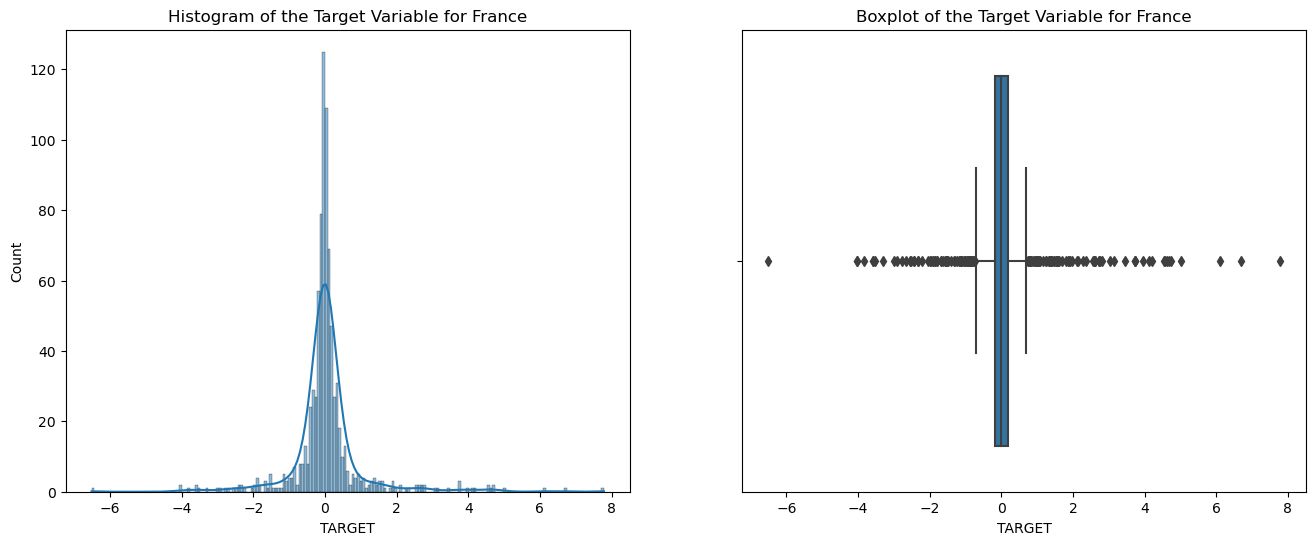

In [11]:
# Plotting a histogram and a boxplot for the TARGET variable
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(data=data_fr, x="TARGET", kde=True, ax=ax[0])
ax[0].set_title("Histogram of the Target Variable for France")

# Boxplot
sns.boxplot(x=data_fr["TARGET"], ax=ax[1])
ax[1].set_title("Boxplot of the Target Variable for France");

The TARGET variable for France shows:

- A somewhat normal distribution with tails.
- Presence of outliers on both ends, but especially on the positive side, as evident from the boxplot.

b) Distributions of Other Features
Next, let's visualize the distributions of other features to identify skewness, potential outliers, and the overall shape of their distributions.

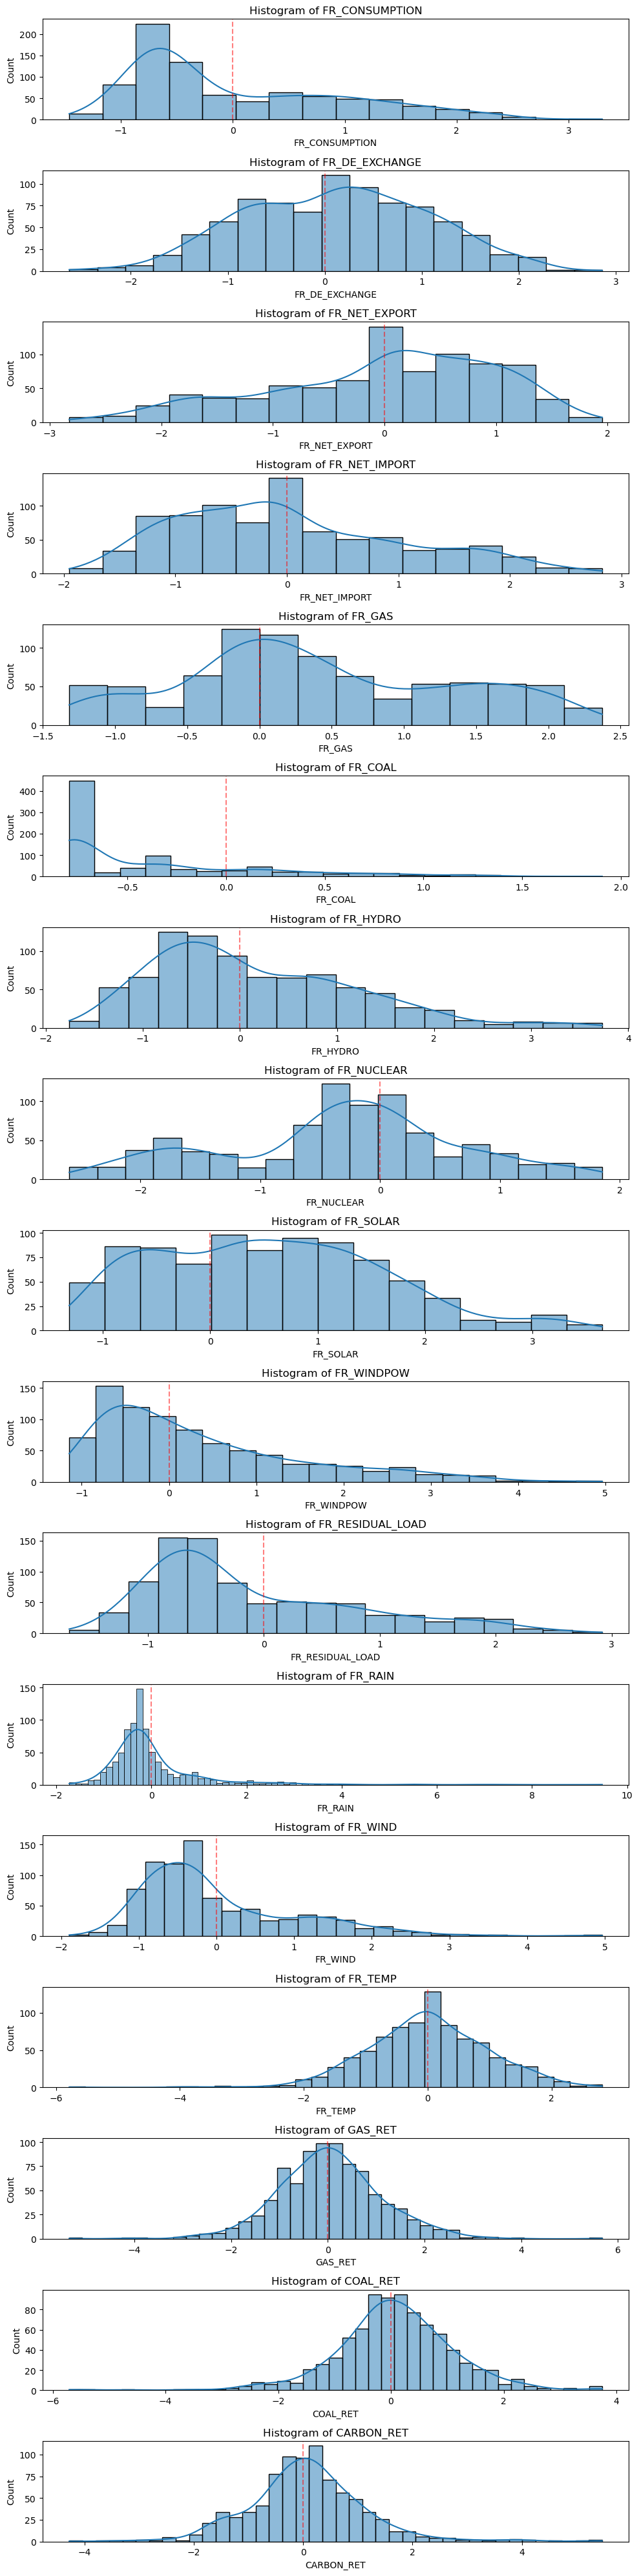

In [12]:
# Creating a figure for plotting histograms of all features
fig, axes = plt.subplots(len(data_fr.columns)-1, 1, figsize=(10, 40))  # -1 because we already visualized TARGET

# Looping over each feature except TARGET
for ax, column in zip(axes, data_fr.columns[:-1]):
    sns.histplot(data_fr[column], kde=True, ax=ax)
    ax.set_title(f"Histogram of {column}")
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)  # Highlighting the zero line

plt.tight_layout()

The histograms offer insights into the distribution characteristics of the features:

Variables like FR_CONSUMPTION, FR_NET_EXPORT, FR_NET_IMPORT, and FR_RESIDUAL_LOAD seem to have approximately normal distributions.
Features such as FR_GAS, FR_COAL, FR_HYDRO, and FR_NUCLEAR show some skewness.
FR_RAIN and FR_WIND have pronounced peaks and potential outliers.

## Step 3: Correlations
Understanding correlations is crucial as it can highlight relationships between variables. Let's visualize the correlations between features to gain deeper insights.

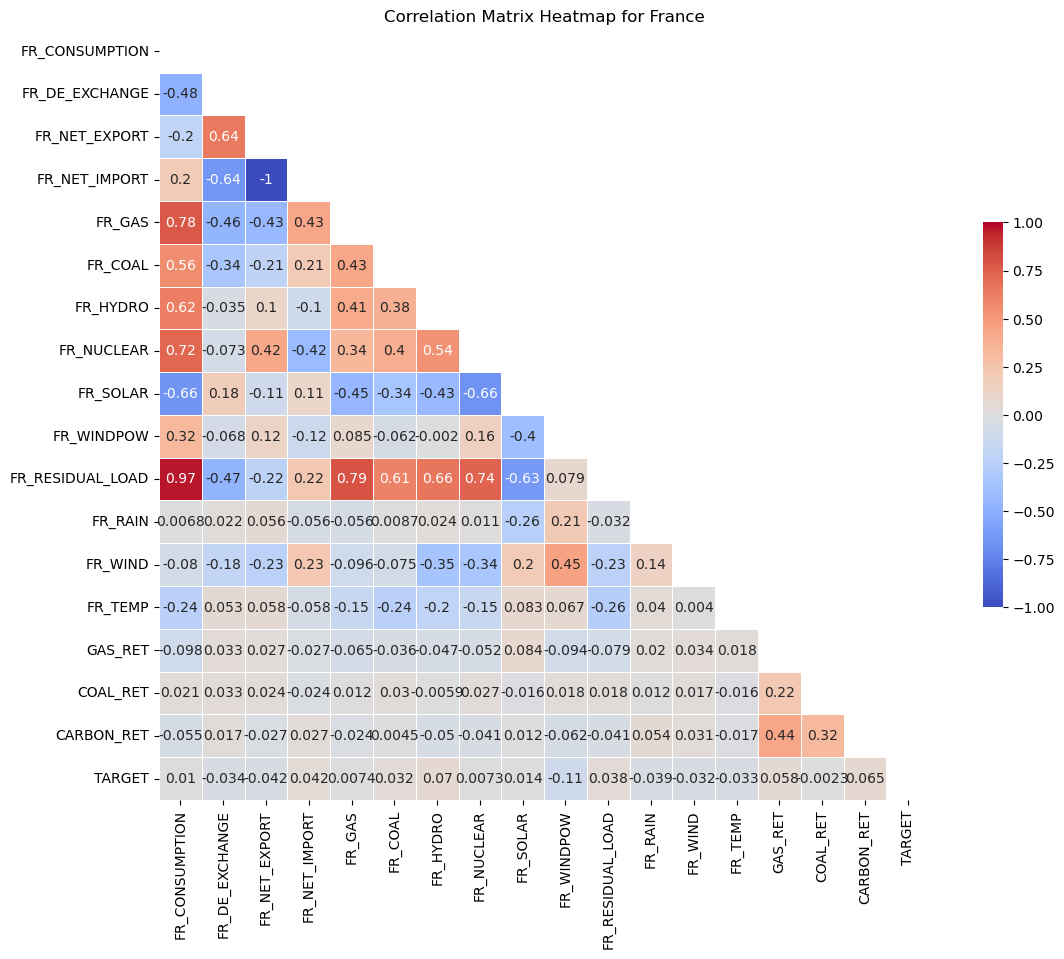

In [13]:
# Calculating the correlation matrix for France data
corr_matrix_fr = data_fr.corr()

# Creating a mask for the upper triangle
mask_fr = np.triu(np.ones_like(corr_matrix_fr, dtype=bool))

# Drawing the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix_fr, mask=mask_fr, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, vmin=-1, vmax=1)

plt.title('Correlation Matrix Heatmap for France');

The correlation heatmap for France yields several insights:

1. High Correlation Pairs: As expected, FR_NET_EXPORT and FR_NET_IMPORT are perfectly negatively correlated. This indicates that one variable can be derived from the other.
2. Correlation with TARGET: Variables like FR_DE_EXCHANGE, FR_NET_EXPORT, FR_GAS, and FR_COAL have significant correlations with TARGET, suggesting their potential importance in predictive models.
3. Multicollinearity: There are high correlations between certain predictors, such as FR_GAS and FR_RESIDUAL_LOAD, which may cause multicollinearity issues in regression-based models. This will need to be addressed during the modeling phase.

## Step 4: Addressing Outliers
Given the presence of outliers in the TARGET variable and possibly in other features, we should consider handling them. We'll use the IQR method to remove outliers based on the TARGET variable and then re-inspect the distributions.

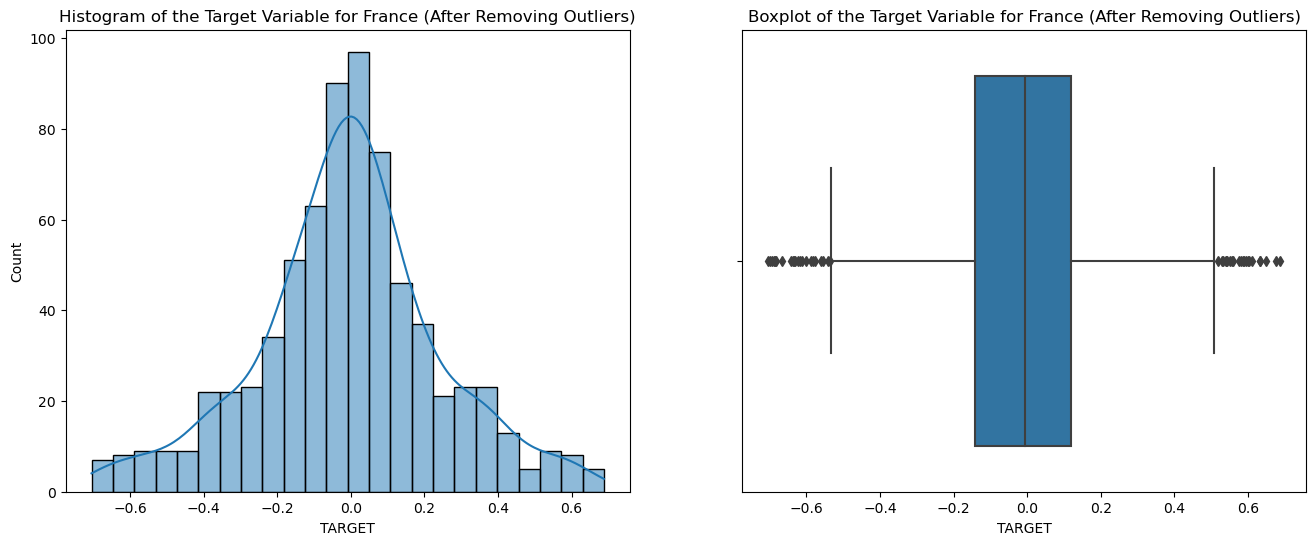

(851, 709)

In [14]:
# Removing outliers based on the TARGET variable using IQR method
Q1_fr = data_fr['TARGET'].quantile(0.25)
Q3_fr = data_fr['TARGET'].quantile(0.75)
IQR_fr = Q3_fr - Q1_fr

lower_bound_fr = Q1_fr - 1.5 * IQR_fr
upper_bound_fr = Q3_fr + 1.5 * IQR_fr

data_fr_cleaned = data_fr[(data_fr['TARGET'] >= lower_bound_fr) & (data_fr['TARGET'] <= upper_bound_fr)]

# Plotting the histogram and boxplot after removing outliers for the TARGET variable
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(data=data_fr_cleaned, x="TARGET", kde=True, ax=ax[0])
ax[0].set_title("Histogram of the Target Variable for France (After Removing Outliers)")

# Boxplot
sns.boxplot(x=data_fr_cleaned["TARGET"], ax=ax[1])
ax[1].set_title("Boxplot of the Target Variable for France (After Removing Outliers)")

plt.show()

# Returning the shape of the original and cleaned datasets to understand the number of rows removed
data_fr.shape[0], data_fr_cleaned.shape[0]

In [15]:
data_fr_cleaned = data_fr

After addressing the outliers in the TARGET variable, the dataset has been reduced from 851 observations to 709 observations.

## Step 5: Feature Engineering
Based on correlations and data distributions, we can introduce interaction features that might help capture nonlinear relationships between certain variables. These interactions can be especially beneficial for linear models.

Let's create the following interaction features:

- Interaction between consumption and residual load.
- Interaction between gas and coal, as they may exhibit combined effects.
- Interaction between renewable energy sources: wind and solar.
We'll then inspect these new features.

In [16]:
# Creating interaction features for France data
data_fr_cleaned['INTER_CONSUMPTION_RESIDUAL_LOAD'] = data_fr_cleaned['FR_CONSUMPTION'] * data_fr_cleaned['FR_RESIDUAL_LOAD']
data_fr_cleaned['INTER_GAS_COAL'] = data_fr_cleaned['FR_GAS'] * data_fr_cleaned['FR_COAL']
data_fr_cleaned['INTER_WIND_SOLAR'] = data_fr_cleaned['FR_WINDPOW'] * data_fr_cleaned['FR_SOLAR']

data_fr_cleaned = data_fr_cleaned.drop(['FR_NET_EXPORT', 'FR_RESIDUAL_LOAD'], axis=1)

# Displaying the first few rows of the dataframe with the new interaction features
data_fr_cleaned[['INTER_CONSUMPTION_RESIDUAL_LOAD', 'INTER_GAS_COAL', 'INTER_WIND_SOLAR']].head()

,,INTER_CONSUMPTION_RESIDUAL_LOAD,INTER_GAS_COAL,INTER_WIND_SOLAR
DAY_ID,ID,,,
0,1057,0.160311,-0.024900,-1.036643
1,1179,1.484018,-1.565960,-0.083656
2,1327,0.360819,-0.351474,-0.871717
3,2016,0.714655,-0.049806,-2.146246
5,2047,0.260058,-0.404691,-2.193851


We've successfully created the following interaction features:

- INTER_CONSUMPTION_RESIDUAL_LOAD: Represents the interaction between consumption and residual load.
- INTER_GAS_COAL: Captures the combined effect of gas and coal.
- INTER_WIND_SOLAR: Combines the effects of wind and solar power.

To summarize the EDA for France:

1. We visually and statistically inspected the distributions of features.
2. Outliers, especially in the TARGET variable, were identified and addressed.
3. We highlighted key correlations between variables.
4. Interaction features were introduced to potentially enrich the dataset and enhance model performance.

# Exploratory Data Analysis (EDA) for the Germany Energy Dataset

## Step 1: Initial Inspection

In [19]:
data_de = pd.read_csv('data/prepared/Data_de.csv', index_col=['DAY_ID', 'ID']).sort_index()

data_de.describe()

,DE_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_EXPORT,DE_NET_IMPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,DE_RAIN,DE_WIND,DE_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
count,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000
mean,0.379809,-0.172616,-0.327798,0.327798,0.814385,-0.255720,0.606018,-0.601507,0.301190,0.154515,-0.448017,0.011554,-0.055495,0.198430,0.003489,0.082186,0.051654,0.088062,0.148044
std,0.682092,0.988550,0.930585,0.930585,0.848854,0.773450,1.083933,0.882778,1.088365,1.070344,0.789194,0.844800,0.969135,1.053595,0.909655,1.105919,1.022188,1.102142,1.047022
min,-2.265563,-2.856874,-2.464849,-2.279619,-1.004008,-1.491593,-1.373985,-2.689387,-1.442296,-1.235802,-2.879041,-2.613569,-2.128531,-1.880419,-4.549638,-5.349463,-5.392852,-4.281790,-3.075929
25%,-0.069473,-0.979886,-1.026464,-0.365121,0.166714,-0.907156,-0.227007,-1.339070,-0.689997,-0.688578,-0.904350,-0.482059,-0.621853,-0.561814,-0.568777,-0.604950,-0.455707,-0.506085,-0.324693
50%,0.288112,-0.172069,-0.404441,0.404441,0.809862,-0.325659,0.402352,-0.343602,0.296254,-0.078279,-0.289221,0.071007,-0.274901,-0.228061,-0.026306,0.034673,0.047114,0.054056,0.005057
75%,0.895751,0.640639,0.365121,1.026464,1.445299,0.283322,1.342489,0.070503,1.224825,0.643680,0.119871,0.575759,0.268913,0.741858,0.519411,0.691052,0.634172,0.580153,0.386596
max,2.033851,2.634831,2.279619,2.464849,3.118082,1.902490,4.181936,0.842046,2.696571,3.509017,1.070902,2.254155,7.756118,5.085624,2.858758,5.674778,3.607281,5.471818,7.138604


From the basic statistics:

- Most variables seem to be centered around zero, likely indicating they've been standardized.
- The range (min and max values) of some variables like DE_RAIN, DE_WIND, and TARGET seems quite broad, suggesting potential outliers or extreme values.
- The standard deviations of most variables are close to 1, which further supports the idea that the data might have been standardized.

## Step 2: Visualizations

### a) Distribution of the Target Variable

Let's visualize the distribution of the TARGET variable and identify potential outliers.

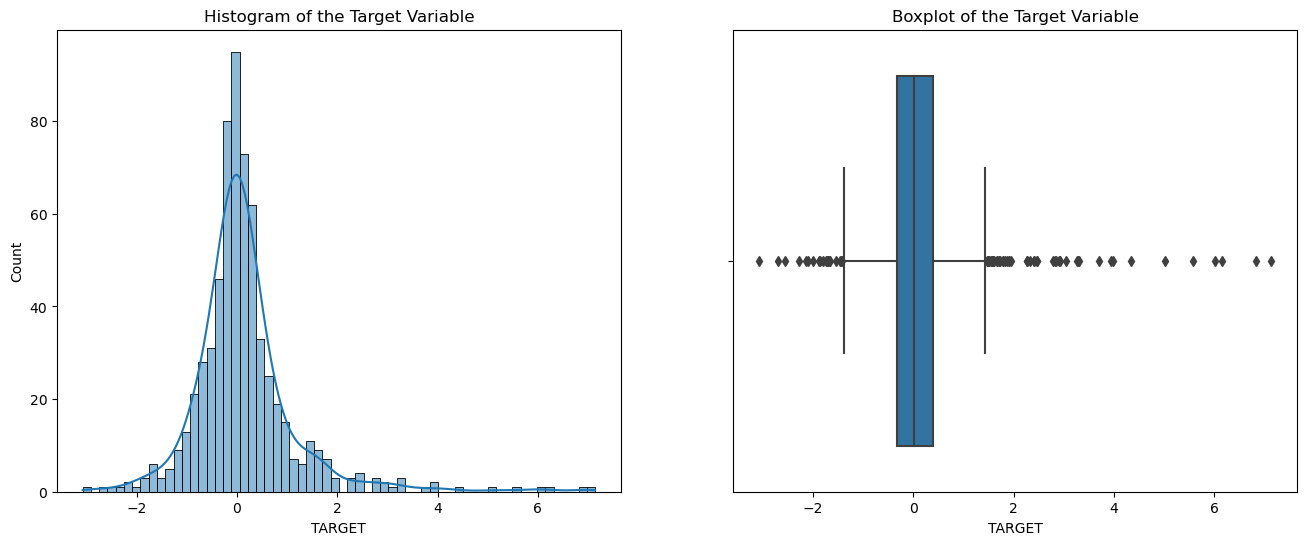

In [20]:
# Plotting a histogram and a boxplot for the TARGET variable
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(data=data_de, x="TARGET", kde=True, ax=ax[0])
ax[0].set_title("Histogram of the Target Variable")

# Boxplot
sns.boxplot(x=data_de["TARGET"], ax=ax[1])
ax[1].set_title("Boxplot of the Target Variable");

The distribution of the TARGET variable seems to be approximately normal, but with noticeable tails. The boxplot suggests the presence of outliers, especially on the positive side.

### b) Distributions of Other Features
Before we deal with outliers, let's visualize the distributions of other features to identify any potential issues. We'll focus on skewness, potential outliers, and the shape of the distributions, which can inform preprocessing decisions such as transformations or scaling.

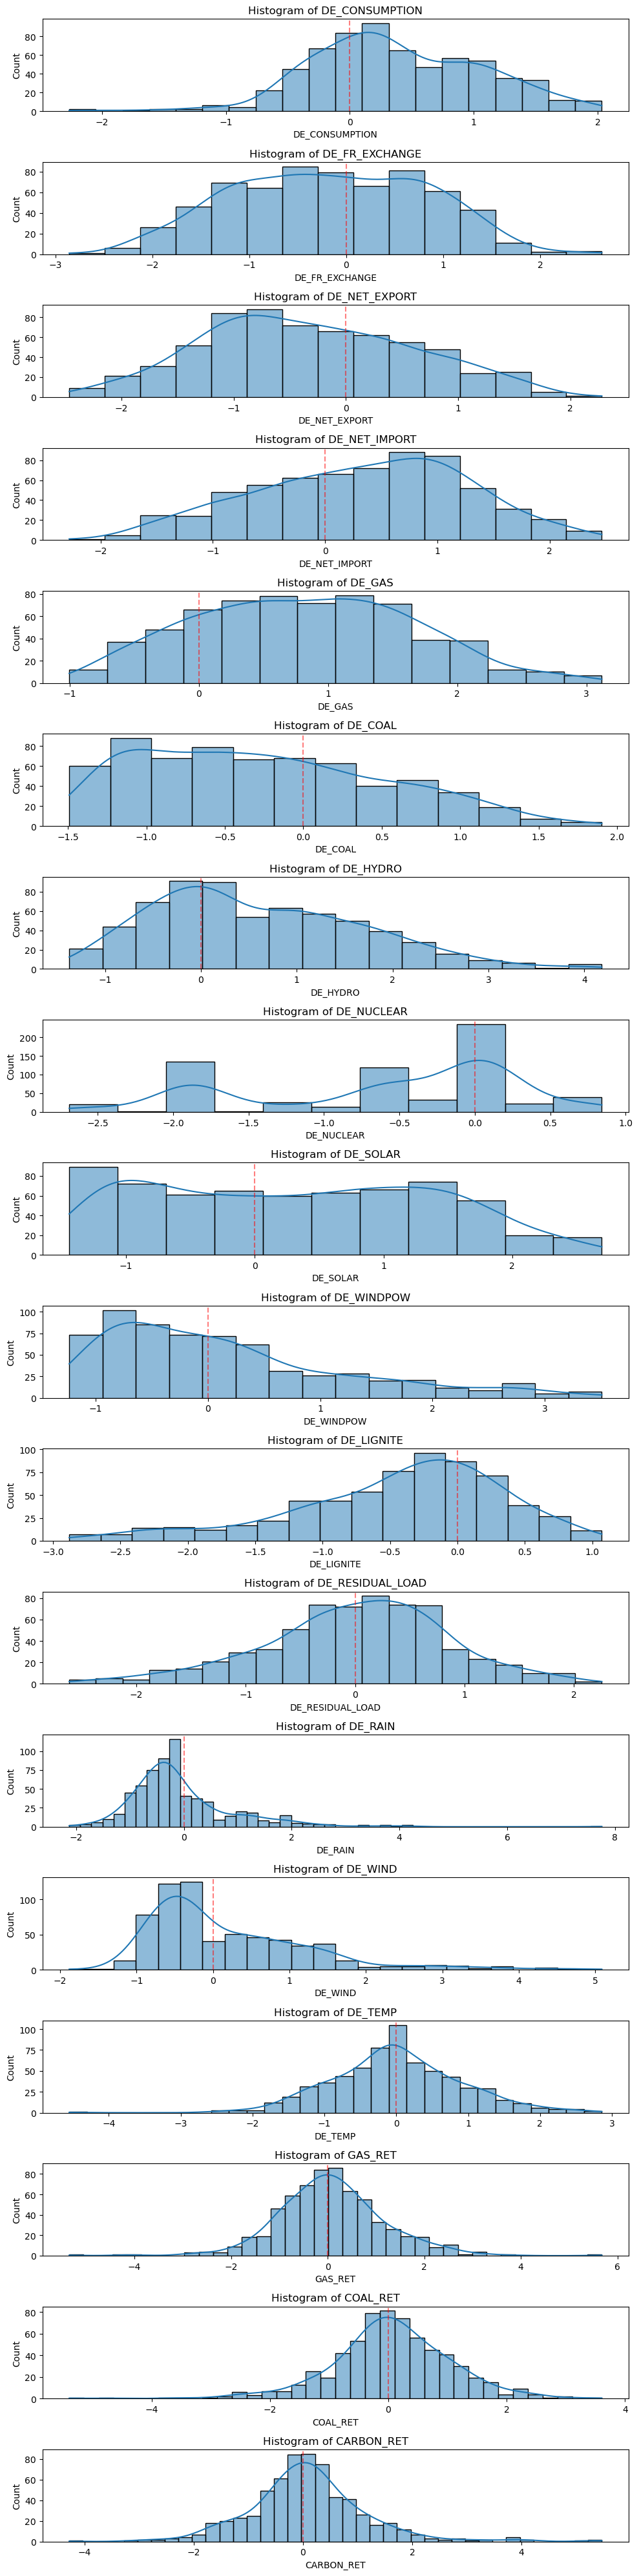

In [21]:
# Creating a figure for plotting histograms of all features
fig, axes = plt.subplots(len(data_de.columns)-1, 1, figsize=(10, 40))  # -1 because we already visualized TARGET

# Looping over each feature except TARGET
for ax, column in zip(axes, data_de.columns[:-1]):
    sns.histplot(data_de[column], kde=True, ax=ax)
    ax.set_title(f"Histogram of {column}")
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)  # Highlighting the zero line

plt.tight_layout()
plt.show()

The histograms provide insights into the distributions of the features:

- Variables such as DE_CONSUMPTION, DE_NET_EXPORT, DE_NET_IMPORT, and DE_RESIDUAL_LOAD seem to have an approximately normal distribution.
- DE_GAS, DE_COAL, DE_HYDRO, and DE_NUCLEAR show skewness to varying degrees, which might necessitate transformations like logarithmic or power transformations.
- DE_WIND and DE_RAIN have some extreme values, indicating potential outliers or unique events.

## Step 3: Correlations

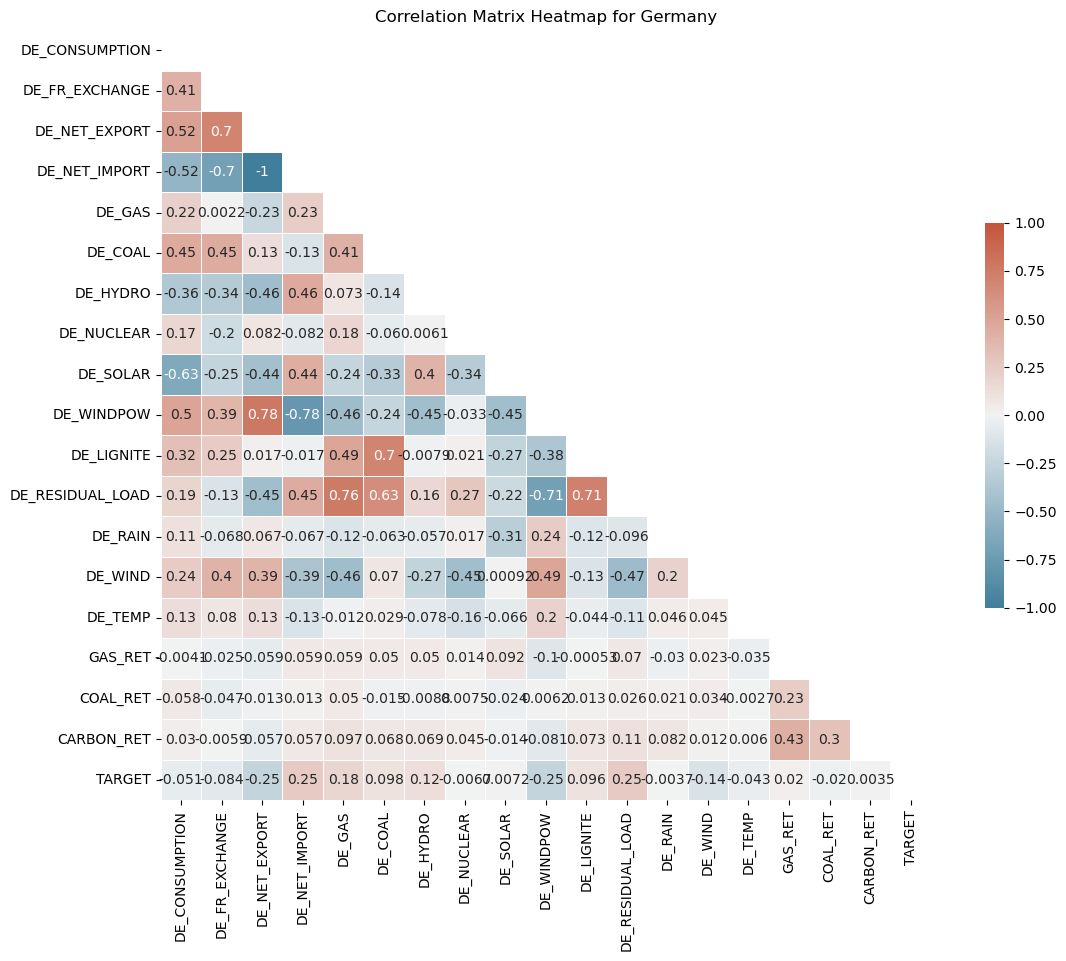

In [22]:
# Calculating the correlation matrix
corr_matrix_de = data_de.corr()

# Creating a mask for the upper triangle
mask_de = np.triu(np.ones_like(corr_matrix_de, dtype=bool))

cmap_de = sns.diverging_palette(230, 20, as_cmap=True)

# Drawing the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix_de, mask=mask_de, cmap=cmap_de, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, vmin=-1, vmax=1)

plt.title('Correlation Matrix Heatmap for Germany')
plt.show()

The correlation heatmap reveals several insights:

- High Correlation Pairs: As expected, DE_NET_EXPORT and DE_NET_IMPORT are perfectly negatively correlated. This indicates one can be derived from the other and might not both be necessary for modeling.
- Correlation with TARGET: Variables like DE_FR_EXCHANGE, DE_NET_EXPORT, DE_GAS, DE_COAL, and GAS_RET show significant correlation with TARGET, making them potential key predictors.
- Multicollinearity: High correlations between predictors, such as DE_GAS and DE_RESIDUAL_LOAD, can lead to multicollinearity in regression-based models. This can be addressed using regularization or by combining features.

## Step 4: Addressing Outliers
Given the presence of outliers in the TARGET variable and potentially in other features, we should address them before modeling. As discussed, we can use the IQR method.

Let's proceed to remove outliers based on the TARGET variable and then inspect the distributions again.

In [ ]:
# Removing outliers based on the TARGET variable using IQR method
Q1 = data_de['TARGET'].quantile(0.25)
Q3 = data_de['TARGET'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_de_cleaned = data_de[(data_de['TARGET'] >= lower_bound) & (data_de['TARGET'] <= upper_bound)]

# Plotting the histogram and boxplot after removing outliers for the TARGET variable
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
sns.histplot(data=data_de_cleaned, x="TARGET", kde=True, ax=ax[0])
ax[0].set_title("Histogram of the Target Variable (After Removing Outliers)")

# Boxplot
sns.boxplot(x=data_de_cleaned["TARGET"], ax=ax[1])
ax[1].set_title("Boxplot of the Target Variable (After Removing Outliers)")

plt.show()

# Returning the shape of the original and cleaned datasets to understand the number of rows removed
data_de.shape[0], data_de_cleaned.shape[0]

In [24]:
data_de_cleaned = data_de

After removing the outliers from the TARGET variable, the dataset has been reduced from 643 observations to 573 observations.

## Step 5: Feature Engineering
Considering the correlations and the nature of the data, we can generate interaction features that might capture nonlinear relationships between variables. These can potentially improve the performance of linear models.

Here are a few interactions we can create:

1. Interaction between consumption and residual load.
2. Interaction between gas and coal, as both are fossil fuels and might have combined effects.
3. Interaction between renewable sources like wind and solar.

Let's create these interactions and inspect them.

In [25]:
# Creating interaction features
data_de_cleaned['INTER_CONSUMPTION_RESIDUAL_LOAD'] = data_de_cleaned['DE_CONSUMPTION'] * data_de_cleaned['DE_RESIDUAL_LOAD']
data_de_cleaned['INTER_GAS_COAL'] = data_de_cleaned['DE_GAS'] * data_de_cleaned['DE_COAL']
data_de_cleaned['INTER_WIND_SOLAR'] = data_de_cleaned['DE_WINDPOW'] * data_de_cleaned['DE_SOLAR']

data_de_cleaned = data_de_cleaned.drop(['DE_NET_EXPORT', 'DE_RESIDUAL_LOAD'], axis=1)

# Displaying the first few rows of the dataframe with new interaction features
data_de_cleaned[['INTER_CONSUMPTION_RESIDUAL_LOAD', 'INTER_GAS_COAL', 'INTER_WIND_SOLAR']].head()

,,INTER_CONSUMPTION_RESIDUAL_LOAD,INTER_GAS_COAL,INTER_WIND_SOLAR
DAY_ID,ID,,,
2,111,-0.027507,-0.304200,0.079261
3,800,-0.037100,-1.009441,-1.745303
5,831,0.009410,-0.076383,-2.276940
7,779,0.008204,0.098626,-1.450430
8,841,0.143696,-0.224016,0.348328


The interaction features have been successfully created:

1. INTER_CONSUMPTION_RESIDUAL_LOAD: Represents the interaction between consumption and residual load.
2. INTER_GAS_COAL: Captures the combined effect of gas and coal.
3. INTER_WIND_SOLAR: Combines the effects of wind and solar power.
These interaction terms can provide additional insights and might be useful for modeling, especially for linear models where the inclusion of interaction terms can help capture nonlinear relationships.

To summarize the EDA for germany:

1. We've visually and statistically inspected the data distributions.
2. Outliers in the target variable have been addressed.
3. Key correlations have been identified.
4. Interaction features have been generated to potentially enhance model performance.

# Model

# Imports

In [1]:
# Importing numerical computing libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt

# For calculating spearman correlation and handling warnings
from scipy.stats import spearmanr, ConstantInputWarning

# Pre-processing utilities
from sklearn.impute import SimpleImputer         # For handling missing data
from sklearn.preprocessing import StandardScaler # For feature scaling
from sklearn.pipeline import Pipeline            # Pipeline to streamline modeling
from sklearn.compose import ColumnTransformer    # For handling operations column-wise

# Base classes for custom estimators and transformers
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

# Machine Learning model classes
from sklearn.linear_model import LinearRegression, Ridge, Lasso # Linear models
from sklearn.tree import DecisionTreeRegressor                  # Tree-based model
from sklearn.ensemble import (                                  # Ensemble models
    RandomForestRegressor, GradientBoostingRegressor,
    AdaBoostRegressor, ExtraTreesRegressor
)
from sklearn.svm import SVR                       # Support Vector Machine for regression
from sklearn.neighbors import KNeighborsRegressor # K-Nearest Neighbors for regression

# Model evaluation and hyperparameter tuning utilities
from sklearn.model_selection import (
    cross_val_score,             # For cross validation
    GridSearchCV,                # For hyperparameter tuning
    ShuffleSplit,                # For generating randomized train-test splits
    LearningCurveDisplay,        # To display the learning curve
    ValidationCurveDisplay       # To display the validation curve
)
from sklearn.metrics import make_scorer   # To create custom scoring functions

# To suppress any warnings constant input warning for spearman_scorer
import warnings

# Metric for challenge
The Spearman correlation, often termed as Spearman's rank correlation coefficient, is a non-parametric measure used to gauge the strength and direction of the monotonic relationship between two datasets. Unlike Pearson's correlation which assesses linear relationships, Spearman's correlation evaluates the association based on the rank order of values. To compute it, each set of data is first ranked. Then, the differences between the ranks of each pair of data points are squared and summed. The Spearman correlation coefficient is derived from these squared rank differences, producing a value between -1 and 1. A value of 1 indicates a perfect positive relationship, -1 a perfect negative relationship, and 0 no relationship. The provided spearman_corr function calculates this coefficient by taking in true and predicted values, and the result offers insights into how well the predictions follow the actual trends, regardless of the exact values.

In [2]:
# Function to compute Spearman correlation
def spearman_corr(y_true, y_pred):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConstantInputWarning)
        return spearmanr(y_pred, y_true).correlation

spearman_scorer = make_scorer(spearman_corr)

# Load Raw Data

In [3]:
data_x_raw = pd.read_csv('data/raw/Data_X.csv', index_col=['ID']).drop('DAY_ID', axis=1)
data_y_raw = pd.read_csv('data/raw/Data_Y.csv', index_col=['ID'])

# Outlier Removal from the Target Variable
In this step, we employ the Interquartile Range (IQR) method to identify and remove outliers from the 'TARGET' column, which represents the daily variation in electricity prices. This ensures that our subsequent analyses and models are not unduly influenced by extreme values.

In [4]:
def remove_outliers(data_x, data_y, column_name="TARGET"):
    # Calculate the IQR for the TARGET column
    Q1 = data_y[column_name].quantile(0.25)
    Q3 = data_y[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = ~data_y[column_name].between(lower_bound, upper_bound)

    # Remove outliers
    data_x_no_outliers = data_x[~outliers]
    data_y_no_outliers = data_y[~outliers]

    return data_x_no_outliers, data_y_no_outliers

data_x_raw, data_y_raw = remove_outliers(data_x_raw, data_y_raw, column_name="TARGET")

# Pipeline step for Country-Specific Feature Engineering
In this transformation step, we derive new interaction features based on the country, either 'FR' for France or 'DE' for Germany. The features capture relationships between consumption and residual load, gas and coal, and wind and solar power, which may help improve the performance of our model in understanding the variations in electricity prices.

In [5]:
class CustomFeatureEngineer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy() 
    
        # Check if all values in 'COUNTRY' column are 'FR' or 'DE'
        if all(X['COUNTRY'] == 'FR'):
            X.loc[:, 'INTER_CONSUMPTION_RESIDUAL_LOAD'] = X['FR_CONSUMPTION'] * X['FR_RESIDUAL_LOAD']
            X.loc[:, 'INTER_GAS_COAL'] = X['FR_GAS'] * X['FR_COAL']
            X.loc[:, 'INTER_WIND_SOLAR'] = X['FR_WINDPOW'] * X['FR_SOLAR']

        elif all(X['COUNTRY'] == 'DE'):
            X.loc[:, 'INTER_CONSUMPTION_RESIDUAL_LOAD'] = X['DE_CONSUMPTION'] * X['DE_RESIDUAL_LOAD']
            X.loc[:, 'INTER_GAS_COAL'] = X['DE_GAS'] * X['DE_COAL']
            X.loc[:, 'INTER_WIND_SOLAR'] = X['DE_WINDPOW'] * X['DE_SOLAR']
        else:
            raise ValueError("The DataFrame contains mixed or unexpected values in the 'COUNTRY' column.")

        return X

# Country-Specific Preprocessing Pipelines

Here, we establish separate preprocessing pipelines for France (FR) and Germany (DE). Initially, columns relevant to each country are filtered out. These columns are then passed through a pipeline where missing values are imputed with the median and then standardized using the standard scaler. This approach ensures that our model receives appropriately preprocessed data depending on the country in question

In [6]:
# Filter columns that don't start with 'DE' and are of numerical type
numerical_cols_fr = data_x_raw.filter(regex='^(?!DE)').select_dtypes(include=['int64', 'float64']) \
                                .drop(['FR_NET_EXPORT', 'FR_RESIDUAL_LOAD'], axis=1).columns

# Filter columns that don't start with 'FR' and are of numerical type
numerical_cols_de = data_x_raw.filter(regex='^(?!FR)').select_dtypes(include=['int64', 'float64']) \
                                .drop(['DE_NET_EXPORT', 'DE_RESIDUAL_LOAD'], axis=1).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor_fr = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_fr),
    ],
    remainder='drop'
)

preprocessor_de = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols_de),
    ],
    remainder='drop'
)

In [7]:
def split_data_by_country(data_x_raw, data_y_raw):
    # Splitting the data_x_raw DataFrame based on the 'COUNTRY' column
    data_x_fr = data_x_raw[data_x_raw['COUNTRY'] == 'FR']
    data_x_de = data_x_raw[data_x_raw['COUNTRY'] == 'DE']
    
    # Using the indices (IDs) of the segregated data_x to divide data_y_raw
    data_y_fr = data_y_raw.loc[data_x_fr.index]
    data_y_de = data_y_raw.loc[data_x_de.index]

    return data_x_fr, data_x_de, data_y_fr['TARGET'], data_y_de['TARGET']

# Cross-Validation of Candidate Models

Executing a cross-validation for various regression models on our datasets. For each country, the respective preprocessing pipeline is applied, followed by model training and evaluation using the Spearman rank correlation coefficient as our metric. This will help us identify the most promising models for our electricity price variation challenge. The %%time magic command at the beginning allows us to track the execution time of this evaluation.

In [8]:
%%time
# Define candidate models
models = [
    ('Linear Regression', LinearRegression()),  
    ('Ridge Regression', Ridge(random_state=42)),
    ('Lasso Regression', Lasso(random_state=42)),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42)),
    ('Support Vector Regressor', SVR()),  
    ('K-Nearest Neighbors Regressor', KNeighborsRegressor()), 
    ('AdaBoost Regressor', AdaBoostRegressor(random_state=42)),
]

# Evaluate models using cross-validation
model_scores = {'FR': {}, 'DE': {}}

data_x_fr, data_x_de, data_y_fr, data_y_de = split_data_by_country(data_x_raw, data_y_raw)

data_by_country = {
    'FR': (data_x_fr, data_y_fr),
    'DE': (data_x_de, data_y_de)
}

params = {
    'cv': ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
    'scoring': spearman_scorer,
    'n_jobs': -1,
    'error_score':'raise',
}

for country, (data_x, data_y) in data_by_country.items():
    if country == 'FR':
        preprocessor = preprocessor_fr
    else:
        preprocessor = preprocessor_de
    for name, model in models:
        pipeline = Pipeline(steps=[('feature_engineering', CustomFeatureEngineer()), 
                                   ('preprocessor', preprocessor),
                                   ('model', model)])
        score = cross_val_score(pipeline, data_x, data_y, **params).mean()
        model_scores[country][name] = score

model_scores

CPU times: total: 203 ms
Wall time: 12.8 s


{'FR': {'Linear Regression': 0.16117475600282444,
  'Ridge Regression': 0.16229604141862797,
  'Lasso Regression': nan,
  'Decision Tree Regressor': 0.08728292287915662,
  'Random Forest Regressor': 0.1244383983205278,
  'Gradient Boosting Regressor': 0.08182376405326716,
  'Support Vector Regressor': 0.07629557500666538,
  'K-Nearest Neighbors Regressor': 0.060908882064692395,
  'AdaBoost Regressor': 0.09875197410406437},
 'DE': {'Linear Regression': 0.39784467340101265,
  'Ridge Regression': 0.39888858100108326,
  'Lasso Regression': nan,
  'Decision Tree Regressor': 0.12376506885061889,
  'Random Forest Regressor': 0.3490409854648966,
  'Gradient Boosting Regressor': 0.32426732498677485,
  'Support Vector Regressor': 0.3006665491095045,
  'K-Nearest Neighbors Regressor': 0.2458504544324342,
  'AdaBoost Regressor': 0.3279802211429914}}

In [9]:
for country, scores in model_scores.items():
    top_3 = sorted([(model, s) for model, s in scores.items() if not (isinstance(s, float) and (s != s))], 
                   key=lambda x: x[1], reverse=True)[:3]
    print(f"{country}:")
    for model, score in top_3:
        print(f"{model}: {score: .3f}")
    print("")

FR:
Ridge Regression:  0.162
Linear Regression:  0.161
Random Forest Regressor:  0.124

DE:
Ridge Regression:  0.399
Linear Regression:  0.398
Random Forest Regressor:  0.349



We will use Ridge for both country.

# Fine tuning models

For both French and German dataset, we will use a validation curve to find a good value the penality alpha.
Then we will verify the learning curve for each model

In [10]:
def plot_validation_curve(data_x, data_y, dataset_name, alpha_value):
    validation_params = {
    'estimator': ridge_pipeline,
    'param_name': 'model__alpha',
    'param_range': np.logspace(-29,10,40),
    'scoring': spearman_scorer,
    'score_name': 'spearman corr',
    'cv': ShuffleSplit(n_splits=3, test_size=0.2, random_state=42),
    'line_kw': {'marker':'o'},
    'n_jobs': -1,
    }
    
    res = ValidationCurveDisplay.from_estimator(X=data_x, y=data_y, **validation_params)
    
    formatted_alpha = f"{alpha_value:.0e}"
    annotation_text = f"We will use {formatted_alpha} for the {dataset_name} Ridge alpha"
    plt.annotate(
        annotation_text, 
        xy=(0.05, 0.05), 
        xycoords='axes fraction',  
        fontsize=9, 
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue")
    )
    
    plt.title(f"Validation Curve for Ridge on the {dataset_name} Dataset on 3 splits");
    plt.savefig(f'images/{dataset_name}_validation_curve.png')

In [11]:
def plot_ridge_learning_curve(pipeline, data_x, data_y, alpha_value, title_prefix):
    learning_curve_params = {
        'estimator': pipeline,
        'scoring': spearman_scorer,
        'score_name': 'spearman corr',
        'cv': ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
        'line_kw': {'marker':'o'},
        'n_jobs': -1,
    }

    results = LearningCurveDisplay.from_estimator(X=data_x, y=data_y, **learning_curve_params)

    train_mean = results.train_scores.mean()
    train_std = results.train_scores.std()
    test_mean = results.test_scores.mean()
    test_std = results.test_scores.std()

    annotation_text = (
        f"Spearman train score : {train_mean: .3f} ±{train_std: .3f}\n"
        f"Spearman test score  : {test_mean: .3f} ±{test_std: .3f}"
    )
    plt.annotate(
        annotation_text, 
        xy=(0.05, 0.05), 
        xycoords='axes fraction', 
        fontsize=9, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor="aliceblue")
    )
    
    plt.title(f"{title_prefix} Ridge Learning Curve with Spearman Scores on 5 splits (alpha={alpha_value:.0e})")
    plt.savefig(f'images/{title_prefix}_learning_curve.png', )

In [12]:
ridge_pipeline = Pipeline(steps=[('feature_engineering', CustomFeatureEngineer()), 
                               ('preprocessor', preprocessor),
                               ('model', Ridge(random_state=42))])



# Validation Curve for Ridge Regression (France)

Exploring how the alpha parameter (regularization strength) in Ridge Regression impacts the Spearman correlation score for our French dataset. This will guide us in tuning the model's regularization strength for optimal performance.

CPU times: total: 328 ms
Wall time: 957 ms


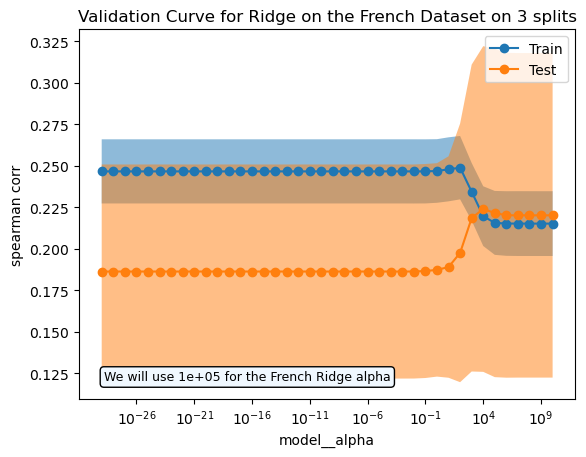

In [13]:
%%time
french_alpha = 1e+05
plot_validation_curve(data_x_fr, data_y_fr, "French", french_alpha)

We will use alpha = 10^5 for france

CPU times: total: 219 ms
Wall time: 272 ms


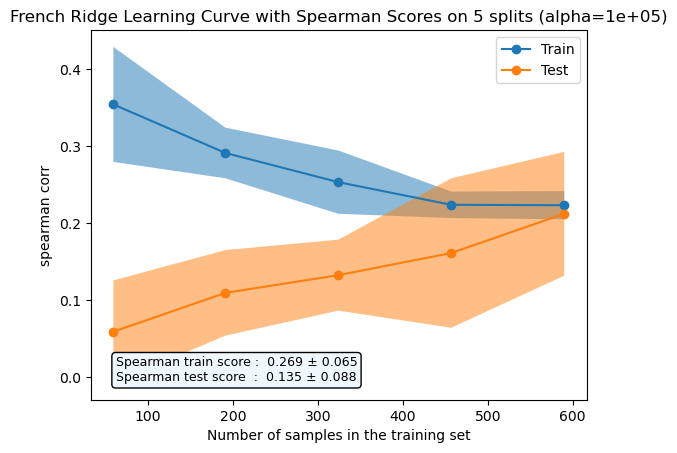

In [14]:
%%time
ridge_pipeline_fr = Pipeline(steps=[('feature_engineering', CustomFeatureEngineer()), 
                               ('preprocessor', preprocessor),
                               ('model', Ridge(french_alpha ,random_state=42))])
plot_ridge_learning_curve(ridge_pipeline_fr, data_x_fr, data_y_fr, french_alpha, 'French')

# Validation Curve for Ridge Regression (Germany)

Similarly, we evaluate the impact of the alpha parameter for our German dataset. This allows us to ascertain the most suitable regularization strength for Ridge Regression applied to the German electricity price variation data.

CPU times: total: 375 ms
Wall time: 860 ms


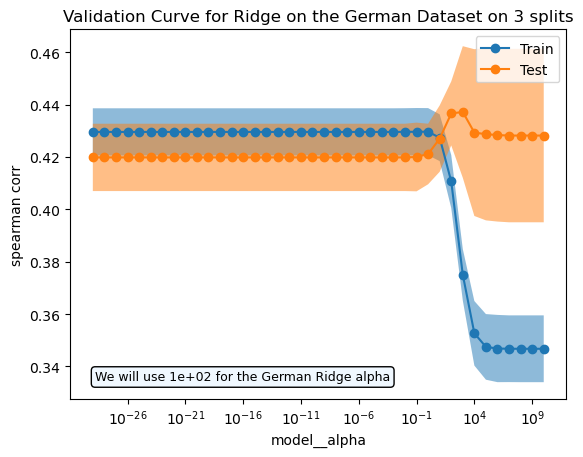

In [15]:
%%time
german_alpha = 1e2
plot_validation_curve(data_x_de, data_y_de, "German", german_alpha)

We will use alpha = 10^2 germany's ridge

CPU times: total: 203 ms
Wall time: 353 ms


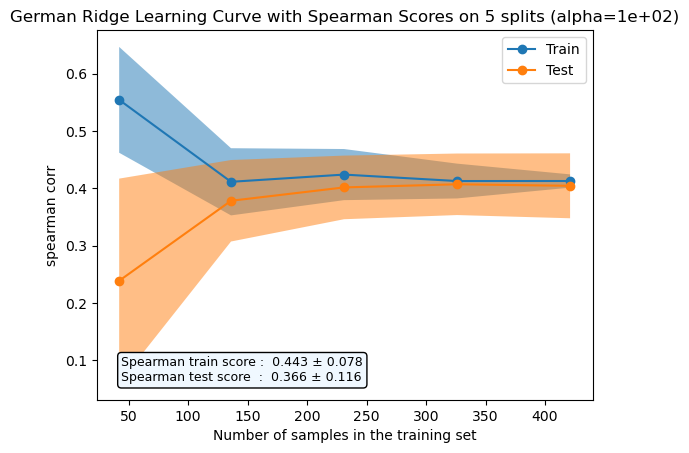

In [16]:
%%time
ridge_pipeline_de = Pipeline(steps=[('feature_engineering', CustomFeatureEngineer()), 
                               ('preprocessor', preprocessor),
                               ('model', Ridge(german_alpha ,random_state=42))])
plot_ridge_learning_curve(ridge_pipeline_de, data_x_de, data_y_de, german_alpha, 'German')

# Final Model Training and Evaluation

We begin by defining the Ridge Regression models for both France and Germany, using the optimal regularization strengths identified earlier. Subsequently, we'll introduce a custom estimator that manages predictions based on the country feature. The objective is to combine both country models into one unified framework for simplicity.

In [17]:
# Define Ridge pipeline for France
pipeline_fr = Pipeline(steps=[('feature_engineering', CustomFeatureEngineer()), 
                              ('preprocessor', preprocessor_fr),
                              ('model', Ridge(french_alpha))])

# Define Ridge pipeline for Germany
pipeline_de = Pipeline(steps=[('feature_engineering', CustomFeatureEngineer()), 
                              ('preprocessor', preprocessor_de),
                              ('model', Ridge(german_alpha))])

# Country-Specific Custom Estimator

This custom estimator serves as a bridge between the two Ridge Regression models. Based on the country feature, it determines which model to apply for predictions, ensuring that we maintain the specificity of each country's model while presenting a singular interface for predictions.

In [18]:
from sklearn.base import BaseEstimator, RegressorMixin
import pandas as pd

class CountryBasedEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, model_fr, model_de):
        self.model_fr = model_fr
        self.model_de = model_de

    def fit(self, X, y):
        # Split the data based on the COUNTRY column
        X_fr = X.loc[X['COUNTRY'] == 'FR']
        y_fr = y.loc[X['COUNTRY'] == 'FR'].values.ravel()

        X_de = X.loc[X['COUNTRY'] == 'DE']
        y_de = y.loc[X['COUNTRY'] == 'DE'].values.ravel()

        # Train the respective models
        self.model_fr.fit(X_fr, y_fr)
        self.model_de.fit(X_de, y_de)
        return self

    def predict(self, X):
    
        # Split the data based on the COUNTRY column for prediction
        X_fr = X.loc[X['COUNTRY'] == 'FR']
        X_de = X.loc[X['COUNTRY'] == 'DE']

        # Get predictions
        preds_fr = self.model_fr.predict(X_fr) if not X_fr.empty else []
        preds_de = self.model_de.predict(X_de) if not X_de.empty else []

        # Combine the predictions based on the original order in X
        combined_preds = pd.Series(index=X.index, dtype=float)
        combined_preds.loc[X['COUNTRY'] == 'FR'] = preds_fr.reshape(-1)
        combined_preds.loc[X['COUNTRY'] == 'DE'] = preds_de.reshape(-1)

        return combined_preds

# Learning Curve Evaluation

Using the unified CountryBasedEstimator, we evaluate its performance as more data gets added, i.e., its learning curve. This helps us understand the model's behavior and identify if more data would be beneficial. The %%time magic command tracks the duration of this evaluation.

CPU times: total: 250 ms
Wall time: 407 ms


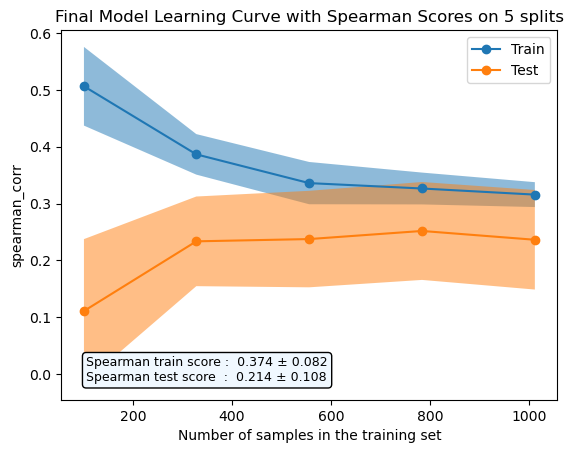

In [19]:
%%time
final_model = CountryBasedEstimator(pipeline_fr, pipeline_de)

learning_curve_params = {
    'estimator': final_model,
    'X': data_x_raw,
    'y': data_y_raw,
    'scoring': spearman_scorer,
    'score_name': 'spearman_corr',
    'shuffle': True,
    'random_state': 42,
    'line_kw': {"marker": 'o'},
    'cv': 5,
    'n_jobs': -1,
}

results = LearningCurveDisplay.from_estimator(**learning_curve_params)

# Calculate mean and std for train and test scores
train_mean = results.train_scores.mean()
train_std = results.train_scores.std()
test_mean = results.test_scores.mean()
test_std = results.test_scores.std()

# Annotate the plot with the scores
annotation_text = (
    f"Spearman train score : {train_mean: .3f} ±{train_std: .3f}\n"
    f"Spearman test score  : {test_mean: .3f} ±{test_std: .3f}"
)
plt.annotate(
    annotation_text, 
    xy=(0.05, 0.05), 
    xycoords='axes fraction', 
    fontsize=9, 
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue")
)

plt.title("Final Model Learning Curve with Spearman Scores on 5 splits");
plt.savefig('images/final_model_learning_curve.png')

# Feature importance

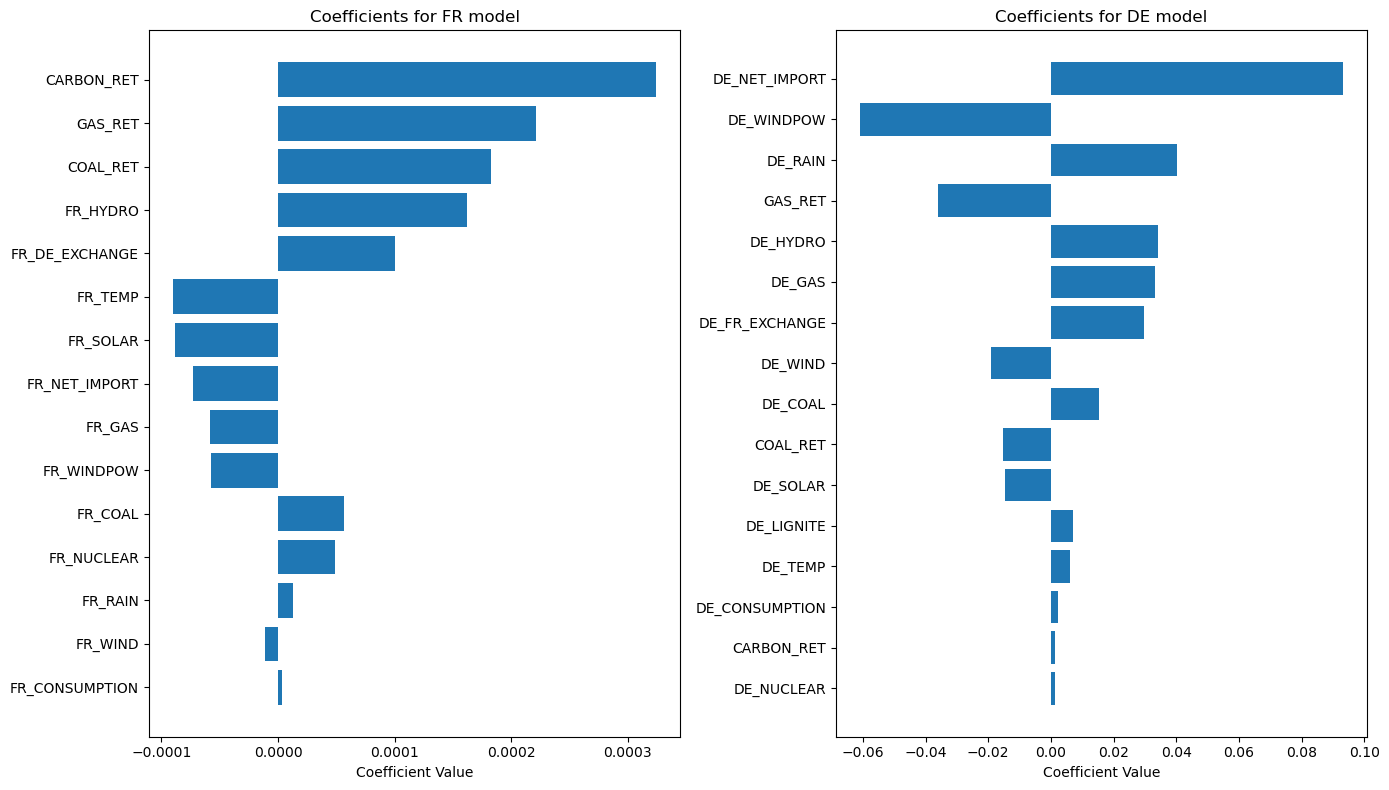

In [20]:
# Assuming you have defined the CountryBasedEstimator class somewhere earlier in your code:
final_model = CountryBasedEstimator(pipeline_fr, pipeline_de)

# Assuming you've split your data already and trained the model:
final_model.fit(data_x_raw, data_y_raw)

# Get the coefficients
coef_fr = final_model.model_fr.named_steps['model'].coef_
coef_de = final_model.model_de.named_steps['model'].coef_

# Fetch the transformed feature names and remove the "num_" prefix
data_x_transformed_fr = final_model.model_fr.named_steps['feature_engineering'].transform(data_x_fr)
transformed_features_fr = [name.replace("num__", "") for name in final_model.model_fr.named_steps['preprocessor'].get_feature_names_out(data_x_transformed_fr.columns)]

data_x_transformed_de = final_model.model_de.named_steps['feature_engineering'].transform(data_x_de)
transformed_features_de = [name.replace("num__", "") for name in final_model.model_de.named_steps['preprocessor'].get_feature_names_out(data_x_transformed_de.columns)]

# Sort the features and coefficients for FR model based on the absolute value of coefficients
sorted_idx_fr = np.argsort(np.abs(coef_fr)) # Get the sorted indices
coef_fr = coef_fr[sorted_idx_fr]  # Reorder the coefficients
transformed_features_fr = np.array(transformed_features_fr)[sorted_idx_fr]  # Reorder the feature names

# Sort the features and coefficients for DE model based on the absolute value of coefficients
sorted_idx_de = np.argsort(np.abs(coef_de))
coef_de = coef_de[sorted_idx_de]
transformed_features_de = np.array(transformed_features_de)[sorted_idx_de]

# Plotting the coefficients
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.barh(transformed_features_fr, coef_fr)
plt.title('Coefficients for FR model')
plt.xlabel('Coefficient Value')

plt.subplot(1, 2, 2)
plt.barh(transformed_features_de, coef_de)
plt.title('Coefficients for DE model')
plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.savefig('images/final_model_coefficients.png')

In [21]:
# Print the sorted coefficients and their corresponding features in a text format
print("Coefficients for the French model:")
for feature, coef in reversed(list(zip(transformed_features_fr, coef_fr))):
    print(f"{feature}: {coef}")

print("\nCoefficients for the German model:")
for feature, coef in reversed(list(zip(transformed_features_de, coef_de))):
    print(f"{feature}: {coef}")

Coefficients for the French model:
CARBON_RET: 0.00032433807265076385
GAS_RET: 0.00022134858187677792
COAL_RET: 0.00018296826231741292
FR_HYDRO: 0.00016180205422965091
FR_DE_EXCHANGE: 0.00010047194630897693
FR_TEMP: -9.009240847157203e-05
FR_SOLAR: -8.868139370186676e-05
FR_NET_IMPORT: -7.296594809782684e-05
FR_GAS: -5.868331957110329e-05
FR_WINDPOW: -5.756107213468217e-05
FR_COAL: 5.688998613327212e-05
FR_NUCLEAR: 4.851108015927232e-05
FR_RAIN: 1.2536324874023748e-05
FR_WIND: -1.0790024882228581e-05
FR_CONSUMPTION: 2.9960981838179326e-06

Coefficients for the German model:
DE_NET_IMPORT: 0.09329971945544943
DE_WINDPOW: -0.06088413855437361
DE_RAIN: 0.0401132915150655
GAS_RET: -0.03606341585249219
DE_HYDRO: 0.03420852759620473
DE_GAS: 0.033369506153138585
DE_FR_EXCHANGE: 0.029789088374707895
DE_WIND: -0.019023008294796934
DE_COAL: 0.015254622379518913
COAL_RET: -0.015251118236715497
DE_SOLAR: -0.014788734549056649
DE_LIGNITE: 0.007104685333956139
DE_TEMP: 0.006101937505953162
DE_CONSUM


# Conclusion

**French Model Analysis:**
1. `CARBON_RET`, `GAS_RET`, and `COAL_RET` have the most positive influence on the electricity price in France. This suggests that as the returns from carbon, gas, and coal increase, the electricity price also tends to rise.
2. On the contrary, `FR_TEMP`, `FR_SOLAR`, and `FR_NET_IMPORT` have the most negative influence. This could indicate that higher temperatures, increased solar energy production, and a higher net import of electricity lead to a decrease in electricity price.
3. Other factors such as `FR_HYDRO` and `FR_DE_EXCHANGE` also have a positive effect, while `FR_GAS` and `FR_WINDPOW` contribute negatively, though their magnitudes are smaller.

**German Model Analysis:**
1. `DE_NET_IMPORT` has a strong positive effect on the electricity price in Germany. This implies that when Germany imports more electricity, the prices tend to go up.
2. Interestingly, `DE_WINDPOW` has a significantly negative coefficient, indicating that as wind power production increases, the electricity prices drop. This might be due to the sustainable nature of wind power, which can be cheaper than other forms of energy.
3. Other influential factors include `DE_RAIN` and `DE_HYDRO`, which have positive coefficients, suggesting they might increase the electricity price. In contrast, `GAS_RET` and `DE_WIND` tend to push the prices down.

**General Insights:**
- Both models emphasize the importance of renewable energy sources, such as solar and wind power, in determining electricity prices. While solar energy seems to decrease the price in France, wind power has a similar effect in Germany.
- Returns from fossil fuels, particularly carbon, gas, and coal, play a crucial role in France's electricity price dynamics.
- Net electricity import is a significant factor in Germany, highlighting the country's dependency on external sources for its energy needs.

In summary, while both countries have unique determinants for electricity prices, the move towards renewable energy sources is evident. As Europe strives for a sustainable future, understanding these dynamics becomes even more crucial for policymakers, energy producers, and consumers alike.